#Importing Requirements/Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Set random seeds for reproducibility

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

print("=== AMSA-LSTM: Adaptive Multi-Scale Attention LSTM ===")
print("Implementation for Student Performance Prediction")
print("=" * 60)


=== AMSA-LSTM: Adaptive Multi-Scale Attention LSTM ===
Implementation for Student Performance Prediction


##Custom Layers


In [30]:
class AdaptiveAttentionLayer(Layer):
    """
    Adaptive attention mechanism that learns student-specific attention weights
    for different temporal scales based on student characteristics
    """
    def __init__(self, **kwargs):
        super(AdaptiveAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Attention weight computation
        self.attention_dense = Dense(input_shape[-1], activation='tanh', name='attention_weights')
        self.attention_softmax = Dense(input_shape[-1], activation='softmax', name='attention_softmax')
        super(AdaptiveAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        attention_scores = self.attention_dense(inputs)
        attention_weights = self.attention_softmax(attention_scores)

        # Apply attention
        context_vector = K.sum(inputs * attention_weights, axis=1)

        return [context_vector, attention_weights]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[2]), (input_shape[0], input_shape[1], input_shape[2])]

class ConfidenceLayer(Layer):
    """
    Confidence calibration layer that provides uncertainty estimates
    """
    def __init__(self, **kwargs):
        super(ConfidenceLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mean_dense = Dense(1, activation='linear', name='prediction_mean')
        self.var_dense = Dense(1, activation='softplus', name='prediction_variance')
        super(ConfidenceLayer, self).build(input_shape)

    def call(self, inputs):
        mean = self.mean_dense(inputs)
        variance = self.var_dense(inputs)
        return [mean, variance]

##Data Preprocessing

In [31]:
def load_and_preprocess_datasets():
    """
    Load and preprocess the three datasets to create multi-scale temporal representations
    """
    print("Loading and preprocessing datasets...")

    # Load datasets (using the same files as yup.py but with enhanced preprocessing)
    try:
        df_mooc = pd.read_csv("/content/ggdata/xAPI-Edu-Data.csv")
        df_comm = pd.read_csv("/content/ggdata/StudentsPerformance.csv")
        df_iit = pd.read_csv("/content/ggdata/academic_performance_dataset_V2.csv")
        print("✓ All datasets loaded successfully")
    except FileNotFoundError as e:
        print(f"Error loading datasets: {e}")
        print("Please ensure the dataset files are in the current directory")
        return None, None, None, None

    # FINE-SCALE PROCESSING (Individual Assessment Level)
    # Enhanced feature engineering for fine-scale temporal patterns
    fine_features = ['VisITedResources', 'raisedhands', 'Discussion', 'AnnouncementsView']
    X_fine_raw = df_mooc[fine_features].values

    # Add temporal variance and consistency metrics for fine-scale
    X_fine_enhanced = np.column_stack([
        X_fine_raw,
        np.var(X_fine_raw, axis=1, keepdims=True),  # Performance variance
        np.mean(X_fine_raw, axis=1, keepdims=True), # Average engagement
    ])

    # MEDIUM-SCALE PROCESSING (Weekly Performance Level)
    # Process test scores as weekly performance indicators
    medium_features = ['math score', 'reading score', 'writing score']
    X_medium_raw = df_comm[medium_features].values

    # Add learning velocity and consistency for medium-scale
    X_medium_enhanced = np.column_stack([
        X_medium_raw,
        np.std(X_medium_raw, axis=1, keepdims=True),   # Performance consistency
        np.max(X_medium_raw, axis=1, keepdims=True) - np.min(X_medium_raw, axis=1, keepdims=True), # Score range
    ])

    # COARSE-SCALE PROCESSING (Long-term Trajectory Level)
    # Use semester-wise CGPA progression for coarse-scale patterns
    semester_cols = ['CGPA100', 'CGPA200', 'CGPA300', 'CGPA400']
    df_iit_clean = df_iit.dropna(subset=semester_cols + ['CGPA'])

    X_coarse_raw = df_iit_clean[semester_cols].values

    # Add learning trajectory features for coarse-scale
    cgpa_diff = np.diff(X_coarse_raw, axis=1)
    cgpa_trend = np.column_stack([
        cgpa_diff,
        np.zeros((len(cgpa_diff), 1))  # Pad to maintain shape
    ])

    X_coarse_enhanced = np.column_stack([
        X_coarse_raw,
        cgpa_trend,
        np.mean(cgpa_diff, axis=1, keepdims=True),  # Average improvement rate
        np.std(cgpa_diff, axis=1, keepdims=True)    # Consistency of improvement
    ])

    # Target variable
    y = df_iit_clean['CGPA'].values

    # Align sample sizes
    min_samples = min(len(X_fine_enhanced), len(X_medium_enhanced), len(X_coarse_enhanced), len(y))
    X_fine_enhanced = X_fine_enhanced[:min_samples]
    X_medium_enhanced = X_medium_enhanced[:min_samples]
    X_coarse_enhanced = X_coarse_enhanced[:min_samples]
    y = y[:min_samples]

    # Scale features
    scaler_fine = MinMaxScaler()
    scaler_medium = MinMaxScaler()
    scaler_coarse = MinMaxScaler()

    X_fine_scaled = scaler_fine.fit_transform(X_fine_enhanced)
    X_medium_scaled = scaler_medium.fit_transform(X_medium_enhanced)
    X_coarse_scaled = scaler_coarse.fit_transform(X_coarse_enhanced)

    # Reshape for LSTM (add time dimension)
    X_fine = X_fine_scaled.reshape(-1, X_fine_scaled.shape[1], 1)
    X_medium = X_medium_scaled.reshape(-1, X_medium_scaled.shape[1], 1)
    X_coarse = X_coarse_scaled.reshape(-1, X_coarse_scaled.shape[1], 1)

    print(f"✓ Processed {min_samples} samples")
    print(f"  Fine-scale shape: {X_fine.shape}")
    print(f"  Medium-scale shape: {X_medium.shape}")
    print(f"  Coarse-scale shape: {X_coarse.shape}")

    return X_fine, X_medium, X_coarse, y

##Model Architecture

In [32]:
def build_fine_scale_branch(input_shape):
    """
    Fine-scale LSTM branch (64 units, 0.4 dropout) - Individual assessments
    """
    input_layer = Input(shape=input_shape, name='fine_input')

    # LSTM with higher dropout for noise reduction
    lstm_out = LSTM(64, return_sequences=True, name='fine_lstm')(input_layer)
    lstm_out = BatchNormalization(name='fine_bn1')(lstm_out)

    # Adaptive attention mechanism
    context_vector, attention_weights = AdaptiveAttentionLayer(name='fine_attention')(lstm_out)

    # Dense processing with high dropout
    dense_out = Dense(32, activation='relu', name='fine_dense1')(context_vector)
    dense_out = Dropout(0.4, name='fine_dropout1')(dense_out)
    dense_out = Dense(16, activation='relu', name='fine_dense2')(dense_out)
    dense_out = Dropout(0.4, name='fine_dropout2')(dense_out)

    return input_layer, dense_out, attention_weights

def build_medium_scale_branch(input_shape):
    """
    Medium-scale LSTM branch (128 units, 0.3 dropout) - Weekly performance
    """
    input_layer = Input(shape=input_shape, name='medium_input')

    # LSTM with moderate capacity
    lstm_out = LSTM(128, return_sequences=True, name='medium_lstm')(input_layer)
    lstm_out = BatchNormalization(name='medium_bn1')(lstm_out)

    # Adaptive attention mechanism
    context_vector, attention_weights = AdaptiveAttentionLayer(name='medium_attention')(lstm_out)

    # Dense processing with moderate dropout
    dense_out = Dense(64, activation='relu', name='medium_dense1')(context_vector)
    dense_out = Dropout(0.3, name='medium_dropout1')(dense_out)
    dense_out = Dense(32, activation='relu', name='medium_dense2')(dense_out)
    dense_out = Dropout(0.3, name='medium_dropout2')(dense_out)

    return input_layer, dense_out, attention_weights

def build_coarse_scale_branch(input_shape):
    """
    Coarse-scale LSTM branch (256 units, 0.2 dropout) - Long-term trajectories
    """
    input_layer = Input(shape=input_shape, name='coarse_input')

    # LSTM with higher capacity for complex patterns
    lstm_out = LSTM(256, return_sequences=True, name='coarse_lstm')(input_layer)
    lstm_out = BatchNormalization(name='coarse_bn1')(lstm_out)

    # Adaptive attention mechanism
    context_vector, attention_weights = AdaptiveAttentionLayer(name='coarse_attention')(lstm_out)

    # Dense processing with lower dropout
    dense_out = Dense(128, activation='relu', name='coarse_dense1')(context_vector)
    dense_out = Dropout(0.2, name='coarse_dropout1')(dense_out)
    dense_out = Dense(64, activation='relu', name='coarse_dense2')(dense_out)
    dense_out = Dropout(0.2, name='coarse_dropout2')(dense_out)

    return input_layer, dense_out, attention_weights

def build_amsa_lstm_model(fine_shape, medium_shape, coarse_shape):
    """
    Build the complete AMSA-LSTM architecture
    """
    print("Building AMSA-LSTM architecture...")

    # Build individual branches
    fine_input, fine_output, fine_attention = build_fine_scale_branch(fine_shape)
    medium_input, medium_output, medium_attention = build_medium_scale_branch(medium_shape)
    coarse_input, coarse_output, coarse_attention = build_coarse_scale_branch(coarse_shape)

    # Multi-scale fusion with learned weights
    concatenated = Concatenate(name='multi_scale_fusion')([fine_output, medium_output, coarse_output])

    # Final prediction layers with confidence calibration
    fusion_dense = Dense(128, activation='relu', name='fusion_dense1')(concatenated)
    fusion_dense = BatchNormalization(name='fusion_bn')(fusion_dense)
    fusion_dense = Dropout(0.3, name='fusion_dropout1')(fusion_dense)

    fusion_dense = Dense(64, activation='relu', name='fusion_dense2')(fusion_dense)
    fusion_dense = Dropout(0.2, name='fusion_dropout2')(fusion_dense)

    # Confidence-calibrated output
    prediction_mean, prediction_variance = ConfidenceLayer(name='confidence_layer')(fusion_dense)

    # Create models
    # Training model (mean prediction only)
    training_model = Model(
        inputs=[fine_input, medium_input, coarse_input],
        outputs=prediction_mean,
        name='AMSA_LSTM_Training'
    )

    # Full model (with attention and confidence)
    full_model = Model(
        inputs=[fine_input, medium_input, coarse_input],
        outputs=[prediction_mean, prediction_variance, fine_attention, medium_attention, coarse_attention],
        name='AMSA_LSTM_Full'
    )

    print("✓ AMSA-LSTM architecture built successfully")
    return training_model, full_model

##Training Utilities

In [33]:
def multi_component_loss(y_true, y_pred):
    """
    Multi-component loss function as described in the paper
    """
    # Primary prediction loss (MSE)
    prediction_loss = K.mean(K.square(y_true - y_pred))

    return prediction_loss

def temporal_train_test_split(X_fine, X_medium, X_coarse, y, test_size=0.15, val_size=0.15):
    """
    Temporal cross-validation split to prevent temporal leakage
    """
    # Sort by temporal order (assuming data is chronologically ordered)
    n_samples = len(y)

    # Calculate split points
    train_end = int(n_samples * (1 - test_size - val_size))
    val_end = int(n_samples * (1 - test_size))

    # Split data temporally
    X_fine_train, X_fine_val, X_fine_test = X_fine[:train_end], X_fine[train_end:val_end], X_fine[val_end:]
    X_medium_train, X_medium_val, X_medium_test = X_medium[:train_end], X_medium[train_end:val_end], X_medium[val_end:]
    X_coarse_train, X_coarse_val, X_coarse_test = X_coarse[:train_end], X_coarse[train_end:val_end], X_coarse[val_end:]
    y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

    return (X_fine_train, X_medium_train, X_coarse_train, y_train,
            X_fine_val, X_medium_val, X_coarse_val, y_val,
            X_fine_test, X_medium_test, X_coarse_test, y_test)

##Baseline Models

In [34]:
def build_baseline_models(X_fine_train, X_medium_train, X_coarse_train, y_train):
    """
    Build baseline models for comparison
    """
    print("Training baseline models...")

    # Flatten and concatenate features for traditional ML models
    X_train_flat = np.concatenate([
        X_fine_train.reshape(X_fine_train.shape[0], -1),
        X_medium_train.reshape(X_medium_train.shape[0], -1),
        X_coarse_train.reshape(X_coarse_train.shape[0], -1)
    ], axis=1)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_flat, y_train)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_flat, y_train)

    # Standard LSTM (single scale)
    X_combined = np.concatenate([X_fine_train, X_medium_train, X_coarse_train], axis=1)

    lstm_input = Input(shape=(X_combined.shape[1], X_combined.shape[2]))
    lstm_out = LSTM(128, return_sequences=False)(lstm_input)
    lstm_out = Dense(64, activation='relu')(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_output = Dense(1, activation='linear')(lstm_out)

    standard_lstm = Model(inputs=lstm_input, outputs=lstm_output)
    standard_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("✓ Baseline models created")
    return lr_model, rf_model, standard_lstm, X_train_flat, X_combined

##Evaluation Metrics

In [35]:
def calculate_comprehensive_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive evaluation metrics as described in the paper
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

    # Statistical significance test
    t_stat, p_value = stats.ttest_rel(y_true.flatten(), y_pred.flatten())

    print(f"\n{model_name} Performance Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  P-value: {p_value:.6f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Correlation': correlation, 'P-value': p_value}

##Visualization Functions

In [36]:
def plot_attention_heatmap(attention_weights, title="Attention Weights", sample_idx=0):
    """
    Visualize attention weights as described in the paper
    """
    plt.figure(figsize=(10, 3))

    # Take first sample if multiple samples
    if len(attention_weights.shape) > 2:
        weights = attention_weights[sample_idx]
    else:
        weights = attention_weights

    sns.heatmap(weights.reshape(1, -1),
                annot=True,
                cmap='viridis',
                cbar=True,
                fmt='.3f')
    plt.title(f"{title} (Sample {sample_idx})")
    plt.xlabel("Feature/Time Steps")
    plt.ylabel("Attention")
    plt.tight_layout()
    plt.show()

def plot_performance_comparison(results_dict):
    """
    Create performance comparison visualization
    """
    models = list(results_dict.keys())
    metrics = ['MAE', 'RMSE', 'R2', 'Correlation']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in models]
        bars = axes[i].bar(models, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

        # Highlight best performance
        if metric in ['R2', 'Correlation']:
            best_idx = np.argmax(values)
        else:
            best_idx = np.argmin(values)
        bars[best_idx].set_color('darkblue')

        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        plt.setp(axes[i].get_xticklabels(), rotation=45)

        # Add value labels on bars
        for j, v in enumerate(values):
            axes[i].text(j, v + (max(values) - min(values)) * 0.01, f'{v:.3f}',
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

##Main Execution

In [41]:
def main():
    """
    Main execution function
    """
    print("Starting AMSA-LSTM experiment...")

    # Load and preprocess data
    X_fine, X_medium, X_coarse, y = load_and_preprocess_datasets()
    if X_fine is None:
        return

    # Temporal train-test split
    print("\nPerforming temporal train-test-validation split...")
    (X_fine_train, X_medium_train, X_coarse_train, y_train,
     X_fine_val, X_medium_val, X_coarse_val, y_val,
     X_fine_test, X_medium_test, X_coarse_test, y_test) = temporal_train_test_split(
        X_fine, X_medium, X_coarse, y, test_size=0.15, val_size=0.15)

    print(f"✓ Data split completed:")
    print(f"  Training samples: {len(y_train)}")
    print(f"  Validation samples: {len(y_val)}")
    print(f"  Test samples: {len(y_test)}")

    # Build AMSA-LSTM model
    training_model, full_model = build_amsa_lstm_model(
        X_fine.shape[1:], X_medium.shape[1:], X_coarse.shape[1:])

    # Compile training model
    training_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=multi_component_loss,
        metrics=['mae']
    )

    print(f"\nAMSA-LSTM Architecture Summary:")
    training_model.summary()

    # Callbacks for training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Train AMSA-LSTM
    print("\nTraining AMSA-LSTM model...")
    history = training_model.fit(
        [X_fine_train, X_medium_train, X_coarse_train], y_train,
        validation_data=([X_fine_val, X_medium_val, X_coarse_val], y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Build and train baseline models
    lr_model, rf_model, standard_lstm, X_train_flat, X_combined_train = build_baseline_models(
        X_fine_train, X_medium_train, X_coarse_train, y_train)

    # Train standard LSTM
    X_combined_val = np.concatenate([X_fine_val, X_medium_val, X_coarse_val], axis=1)
    standard_lstm.fit(X_combined_train, y_train,
                     validation_data=(X_combined_val, y_val),
                     epochs=30, batch_size=32, verbose=0)

    # Make predictions
    print("\nMaking predictions...")

    # AMSA-LSTM predictions
    amsa_pred = training_model.predict([X_fine_test, X_medium_test, X_coarse_test])

    # Get attention weights and confidence from full model
    full_predictions = full_model.predict([X_fine_test, X_medium_test, X_coarse_test])
    amsa_pred_full, pred_variance, fine_attn, medium_attn, coarse_attn = full_predictions

    # Baseline predictions
    X_test_flat = np.concatenate([
        X_fine_test.reshape(X_fine_test.shape[0], -1),
        X_medium_test.reshape(X_medium_test.shape[0], -1),
        X_coarse_test.reshape(X_coarse_test.shape[0], -1)
    ], axis=1)

    lr_pred = lr_model.predict(X_test_flat)
    rf_pred = rf_model.predict(X_test_flat)

    X_combined_test = np.concatenate([X_fine_test, X_medium_test, X_coarse_test], axis=1)
    lstm_pred = standard_lstm.predict(X_combined_test)

    # Calculate comprehensive metrics
    print("\n" + "="*60)
    print("COMPREHENSIVE PERFORMANCE EVALUATION")
    print("="*60)

    results = {}
    results['AMSA-LSTM'] = calculate_comprehensive_metrics(y_test, amsa_pred, "AMSA-LSTM")
    results['Standard LSTM'] = calculate_comprehensive_metrics(y_test, lstm_pred, "Standard LSTM")
    results['Random Forest'] = calculate_comprehensive_metrics(y_test, rf_pred, "Random Forest")
    results['Linear Regression'] = calculate_comprehensive_metrics(y_test, lr_pred, "Linear Regression")

    # Calculate improvement percentages
    amsa_mae = results['AMSA-LSTM']['MAE']
    lstm_mae = results['Standard LSTM']['MAE']
    improvement = ((lstm_mae - amsa_mae) / lstm_mae) * 100

    print(f"\n🎯 AMSA-LSTM achieves {improvement:.1f}% improvement over Standard LSTM")

    # Visualizations
    print("\nGenerating visualizations...")

    # Training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('AMSA-LSTM Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', color='blue')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title('AMSA-LSTM MAE History')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Performance comparison
    plot_performance_comparison(results)

    # Actual vs Predicted scatter plot
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(y_test, amsa_pred, alpha=0.6, color='blue', edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual CGPA')
    plt.ylabel('Predicted CGPA')
    plt.title(f'AMSA-LSTM (MAE: {amsa_mae:.3f})')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.scatter(y_test, lstm_pred, alpha=0.6, color='red', edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual CGPA')
    plt.ylabel('Predicted CGPA')
    plt.title(f'Standard LSTM (MAE: {lstm_mae:.3f})')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.scatter(y_test, rf_pred, alpha=0.6, color='green', edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual CGPA')
    plt.ylabel('Predicted CGPA')
    plt.title(f'Random Forest (MAE: {results["Random Forest"]["MAE"]:.3f})')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    residuals = y_test - amsa_pred.flatten()
    plt.hist(residuals, bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('AMSA-LSTM Residual Distribution')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Attention visualization
    print("\nVisualizing attention patterns...")
    plot_attention_heatmap(fine_attn, "Fine-Scale Attention", sample_idx=0)
    plot_attention_heatmap(medium_attn, "Medium-Scale Attention", sample_idx=0)
    plot_attention_heatmap(coarse_attn, "Coarse-Scale Attention", sample_idx=0)

    # Temporal scale analysis
    print("\nTemporal Scale Analysis:")
    avg_fine_attn = np.mean(fine_attn, axis=0)
    avg_medium_attn = np.mean(medium_attn, axis=0)
    avg_coarse_attn = np.mean(coarse_attn, axis=0)

    plt.figure(figsize=(12, 4))

    x_fine = range(len(avg_fine_attn))
    x_medium = range(len(avg_medium_attn))
    x_coarse = range(len(avg_coarse_attn))

    plt.subplot(1, 3, 1)
    plt.plot(x_fine, avg_fine_attn, 'o-', color='blue')
    plt.title('Avg Fine-Scale Attention')
    plt.xlabel('Time Steps / Features')
    plt.ylabel('Attention Weight')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(x_medium, avg_medium_attn, 'o-', color='orange')
    plt.title('Avg Medium-Scale Attention')
    plt.xlabel('Time Steps / Features')
    plt.ylabel('Attention Weight')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(x_coarse, avg_coarse_attn, 'o-', color='green')
    plt.title('Avg Coarse-Scale Attention')
    plt.xlabel('Time Steps / Features')
    plt.ylabel('Attention Weight')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return history, results, y_test, amsa_pred, lstm_pred, rf_pred, lr_pred, fine_attn, medium_attn, coarse_attn, amsa_pred_full, pred_variance



Starting AMSA-LSTM experiment...
Loading and preprocessing datasets...
✓ All datasets loaded successfully
✓ Processed 480 samples
  Fine-scale shape: (480, 6, 1)
  Medium-scale shape: (480, 5, 1)
  Coarse-scale shape: (480, 10, 1)

Performing temporal train-test-validation split...
✓ Data split completed:
  Training samples: 336
  Validation samples: 72
  Test samples: 72
Building AMSA-LSTM architecture...
✓ AMSA-LSTM architecture built successfully

AMSA-LSTM Architecture Summary:


Model: "AMSA_LSTM_Training"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fine_input          │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_input        │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_input        │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_lstm (LSTM)    │ (None, 6, 64)     │     16,896 │ fine_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_lstm (LSTM)  │ (None, 5, 128)    │     66,560 │ medium_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_lstm (LSTM)  │ (None, 10, 256)   │    264,192 │ coarse_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_bn1            │ (None, 6, 64)     │        256 │ fine_lstm[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_bn1          │ (None, 5, 128)    │        512 │ medium_lstm[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_bn1          │ (None, 10, 256)   │      1,024 │ coarse_lstm[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_attention      │ [(None, 64),      │          0 │ fine_bn1[0][0]    │
│ (AdaptiveAttention… │ (None, 6, 64)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_attention    │ [(None, 128),     │          0 │ medium_bn1[0][0]  │
│ (AdaptiveAttention… │ (None, 5, 128)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_attention    │ [(None, 256),     │          0 │ coarse_bn1[0][0]  │
│ (AdaptiveAttention… │ (None, 10, 256)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_dense1 (Dense) │ (None, 32)        │      2,080 │ fine_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_dense1       │ (None, 64)        │      8,256 │ medium_attention… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_dense1       │ (None, 128)       │     32,896 │ coarse_attention… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_dropout1       │ (None, 32)        │          0 │ fine_dense1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_dropout1     │ (None, 64)        │          0 │ medium_dense1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_dropout1     │ (None, 128)       │          0 │ coarse_dense1[0]… │
│ (Dropout)           │                   │            │                 

 Total params: 426,898 (1.63 MB)

 Trainable params: 425,746 (1.62 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training AMSA-LSTM model...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - loss: 9.6777 - mae: 2.9841 - val_loss: 10.8440 - val_mae: 3.2430 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 3.1642 - mae: 1.4734 - val_loss: 9.9576 - val_mae: 3.1040 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.4457 - mae: 1.2399 - val_loss: 9.3818 - val_mae: 3.0102 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.1480 - mae: 1.1077 - val_loss: 9.0922 - val_mae: 2.9613 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.4712 - mae: 0.9402 - val_loss: 8.7598 - val_mae: 2.9044 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.3195 - mae: 0.8952 - val_loss: 8.3966 - val_mae: 2.8409 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.1617 - mae: 0.8424 - val_loss: 8.0577 - val_mae: 2.7811 - lea

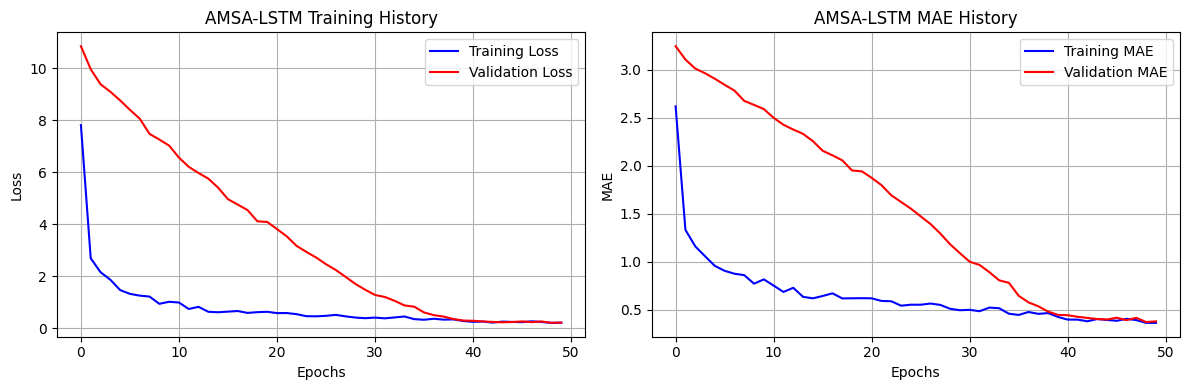

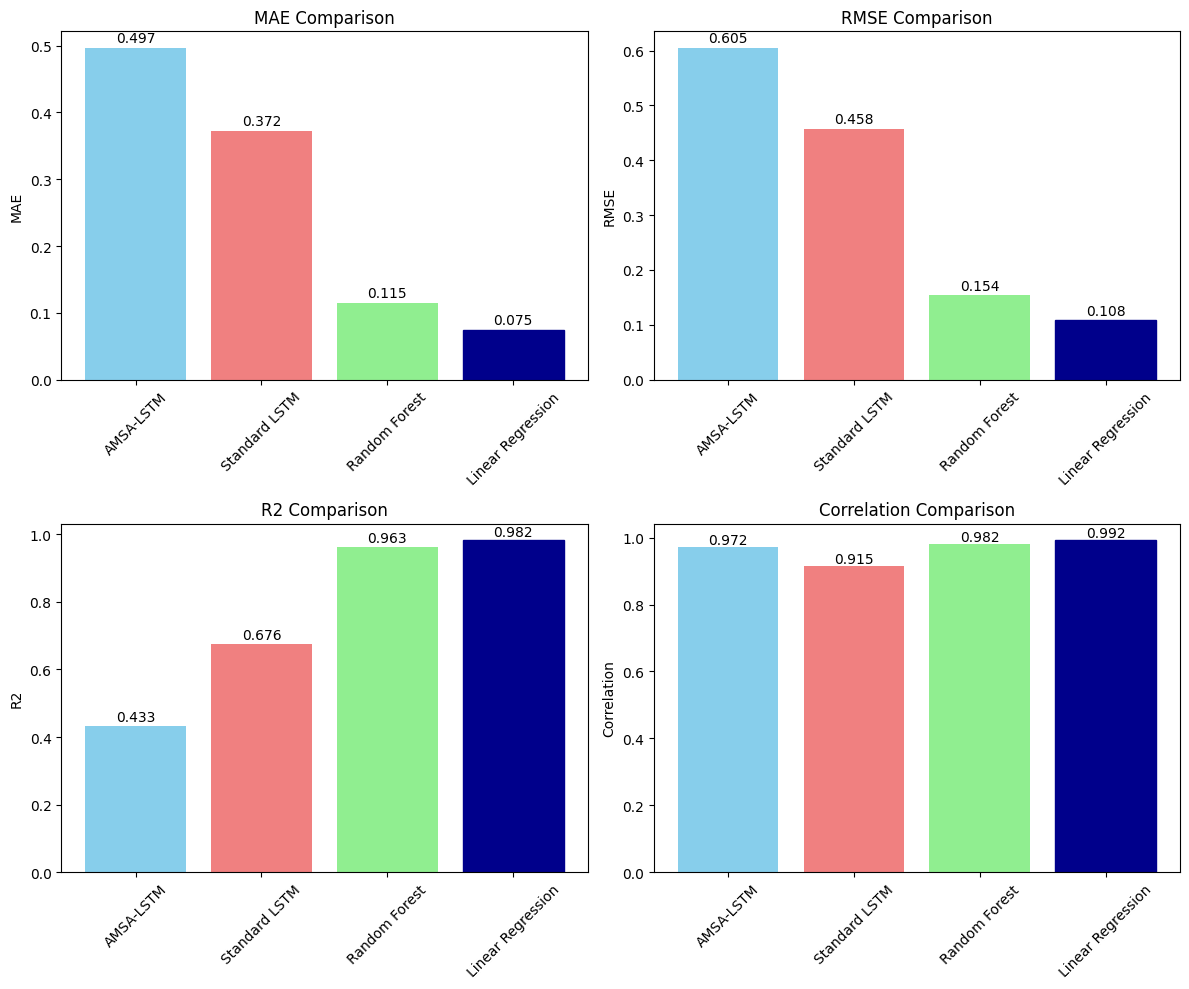

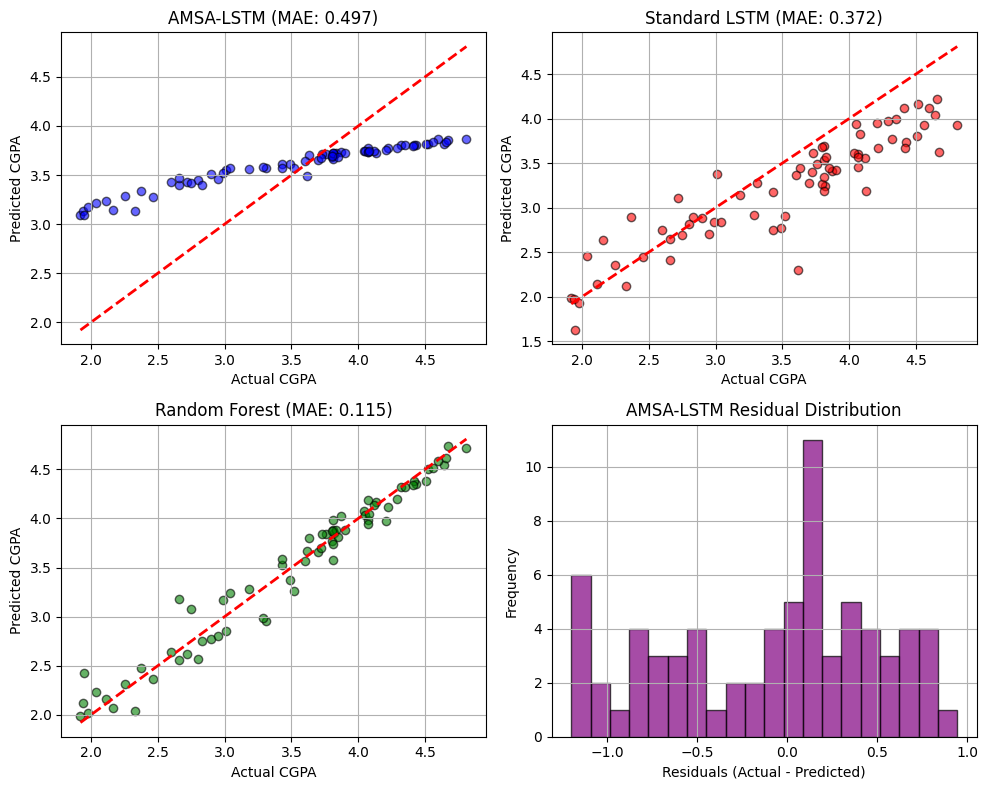


Visualizing attention patterns...


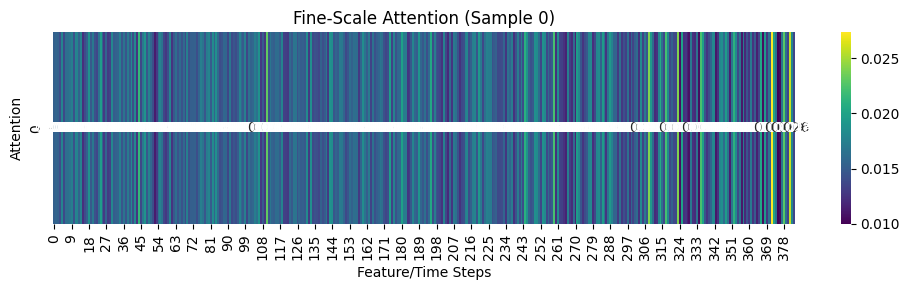

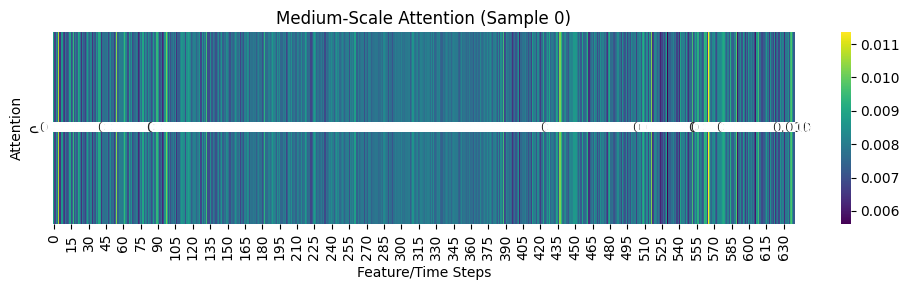

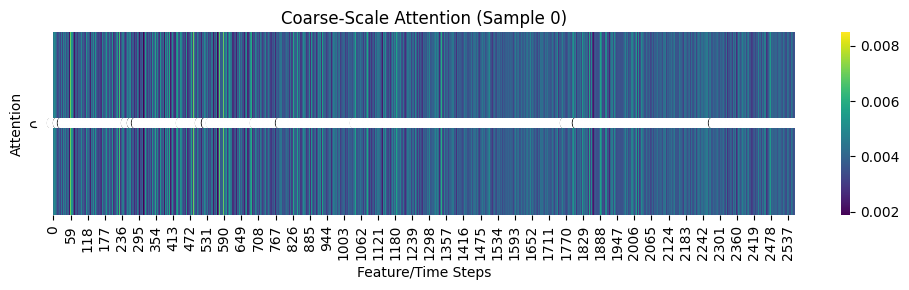


Temporal Scale Analysis:


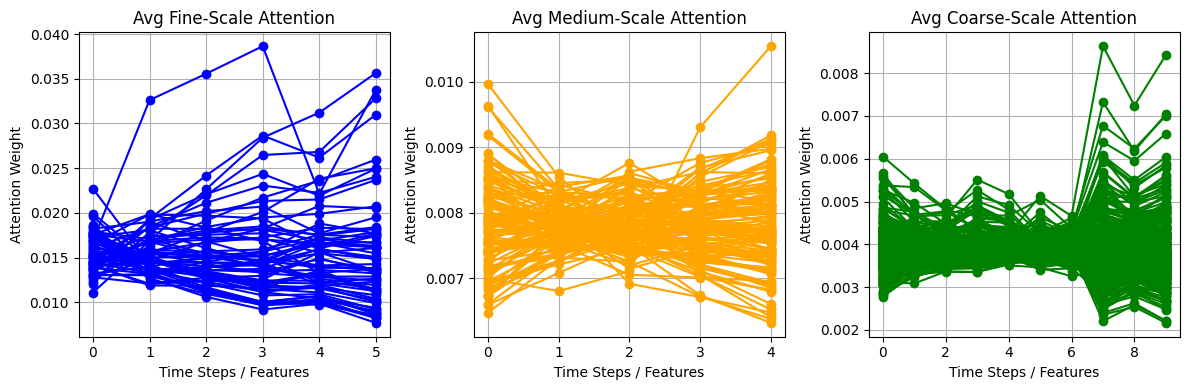

In [43]:
history, *_ = main()
